In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
df = pd.read_csv('training.csv')

df.columns.to_list()

['Date',
 'season_start',
 'home_Expenditure',
 'home_Arrivals',
 'home_Income',
 'home_Departures',
 'home_Balance',
 'away_Expenditure',
 'away_Arrivals',
 'away_Income',
 'away_Departures',
 'away_Balance',
 'PrgC_per90_ATT_home',
 'PrgC_per90_DEF_home',
 'PrgC_per90_MID_home',
 'PrgP_per90_ATT_home',
 'PrgP_per90_DEF_home',
 'PrgP_per90_MID_home',
 'PrgR_per90_ATT_home',
 'PrgR_per90_DEF_home',
 'PrgR_per90_MID_home',
 'Gls_ATT_home',
 'Gls_DEF_home',
 'Gls_MID_home',
 'Ast_ATT_home',
 'Ast_DEF_home',
 'Ast_MID_home',
 'G+A_ATT_home',
 'G+A_DEF_home',
 'G+A_MID_home',
 'G-PK_ATT_home',
 'G-PK_DEF_home',
 'G-PK_MID_home',
 'G+A-PK_ATT_home',
 'G+A-PK_DEF_home',
 'G+A-PK_MID_home',
 'xG_ATT_home',
 'xG_DEF_home',
 'xG_MID_home',
 'xAG_ATT_home',
 'xAG_DEF_home',
 'xAG_MID_home',
 'xG+xAG_ATT_home',
 'xG+xAG_DEF_home',
 'xG+xAG_MID_home',
 'npxG_ATT_home',
 'npxG_DEF_home',
 'npxG_MID_home',
 'npxG+xAG_ATT_home',
 'npxG+xAG_DEF_home',
 'npxG+xAG_MID_home',
 'PrgC_per90_ATT_away',
 'Pr

In [ ]:
data_2020 = df[df['season_start'] == 2020]
data_2020

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['ft_result_encoded'], bins=np.arange(-0.5, 3.5, 1), edgecolor='black', alpha=0.7)
plt.xticks([0, 1, 2], ['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of Match Results for the Home Team')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
from scipy.stats import entropy
given_entropy = entropy(df['ft_result_encoded'].value_counts(normalize=True))
max_entropy = np.log(3)

print(f"Percentage of maximum entropy: {given_entropy / max_entropy * 100:.2f}%, i.e., close to a uniform distribution.")

In [ ]:
numerical_cols = df.drop(columns=['ft_result_encoded', 'Date', 'gameweek', 'season_start']).select_dtypes(include=np.number).columns

#CHOOSE WHICH 16 GRAPHS TO DISPLAY (WE HAVE 153 NUMERICAL COLUMNS)
numerical_cols = numerical_cols[:16]

plt.figure(figsize=(15,10))
for i, col in enumerate(numerical_cols, start=1):
    plt.subplot(4, 4, i)
    sns.boxplot(x='ft_result_encoded', y=col, data=df)
    plt.title(f'{col}')

    plt.tight_layout()
plt.show()

Notice how the _ATT_, _MID_ and _DEF_ stats seem to be very informative of the result (the mean is typically larger for wins)

In [ ]:
# compare distribution of ft_result_encoded over time (season)
plt.figure(figsize=(12, 6))
sns.countplot(x='season_start', hue='ft_result_encoded', data=df)
plt.xlabel('Season Start Year')
plt.ylabel('Count')
plt.title('Distribution of Match Results Over Seasons')
plt.show()

In [ ]:
df[df['season_start'] == 2020].shape[0]

Something strange going on with season starting 2020, we seem to have more than twice the games of oher seasons.

In [ ]:
# plot entropy over seasons
season_entropy = df.groupby('season_start')['ft_result_encoded'].apply(lambda x: entropy(x.value_counts(normalize=True)))
plt.figure(figsize=(10, 5))
plt.plot(season_entropy.index, season_entropy.values, marker='o')
plt.xlabel('Season Start Year')
plt.ylabel('Entropy of Match Results')
plt.ylim(0, np.log(3) + 0.1)
plt.title('Entropy of Match Results Over Seasons')
plt.hlines(y=np.log(3), xmin=2014, xmax=2026, colors='red', linestyles='--', label='Max entropy (ln(3))')
plt.show()

Ignore this stuff down here, trying to get a good game-by-game pred model working

Using features: ['pts_so_far', 'mp_so_far', 'games_remaining', 'prev_season_points']


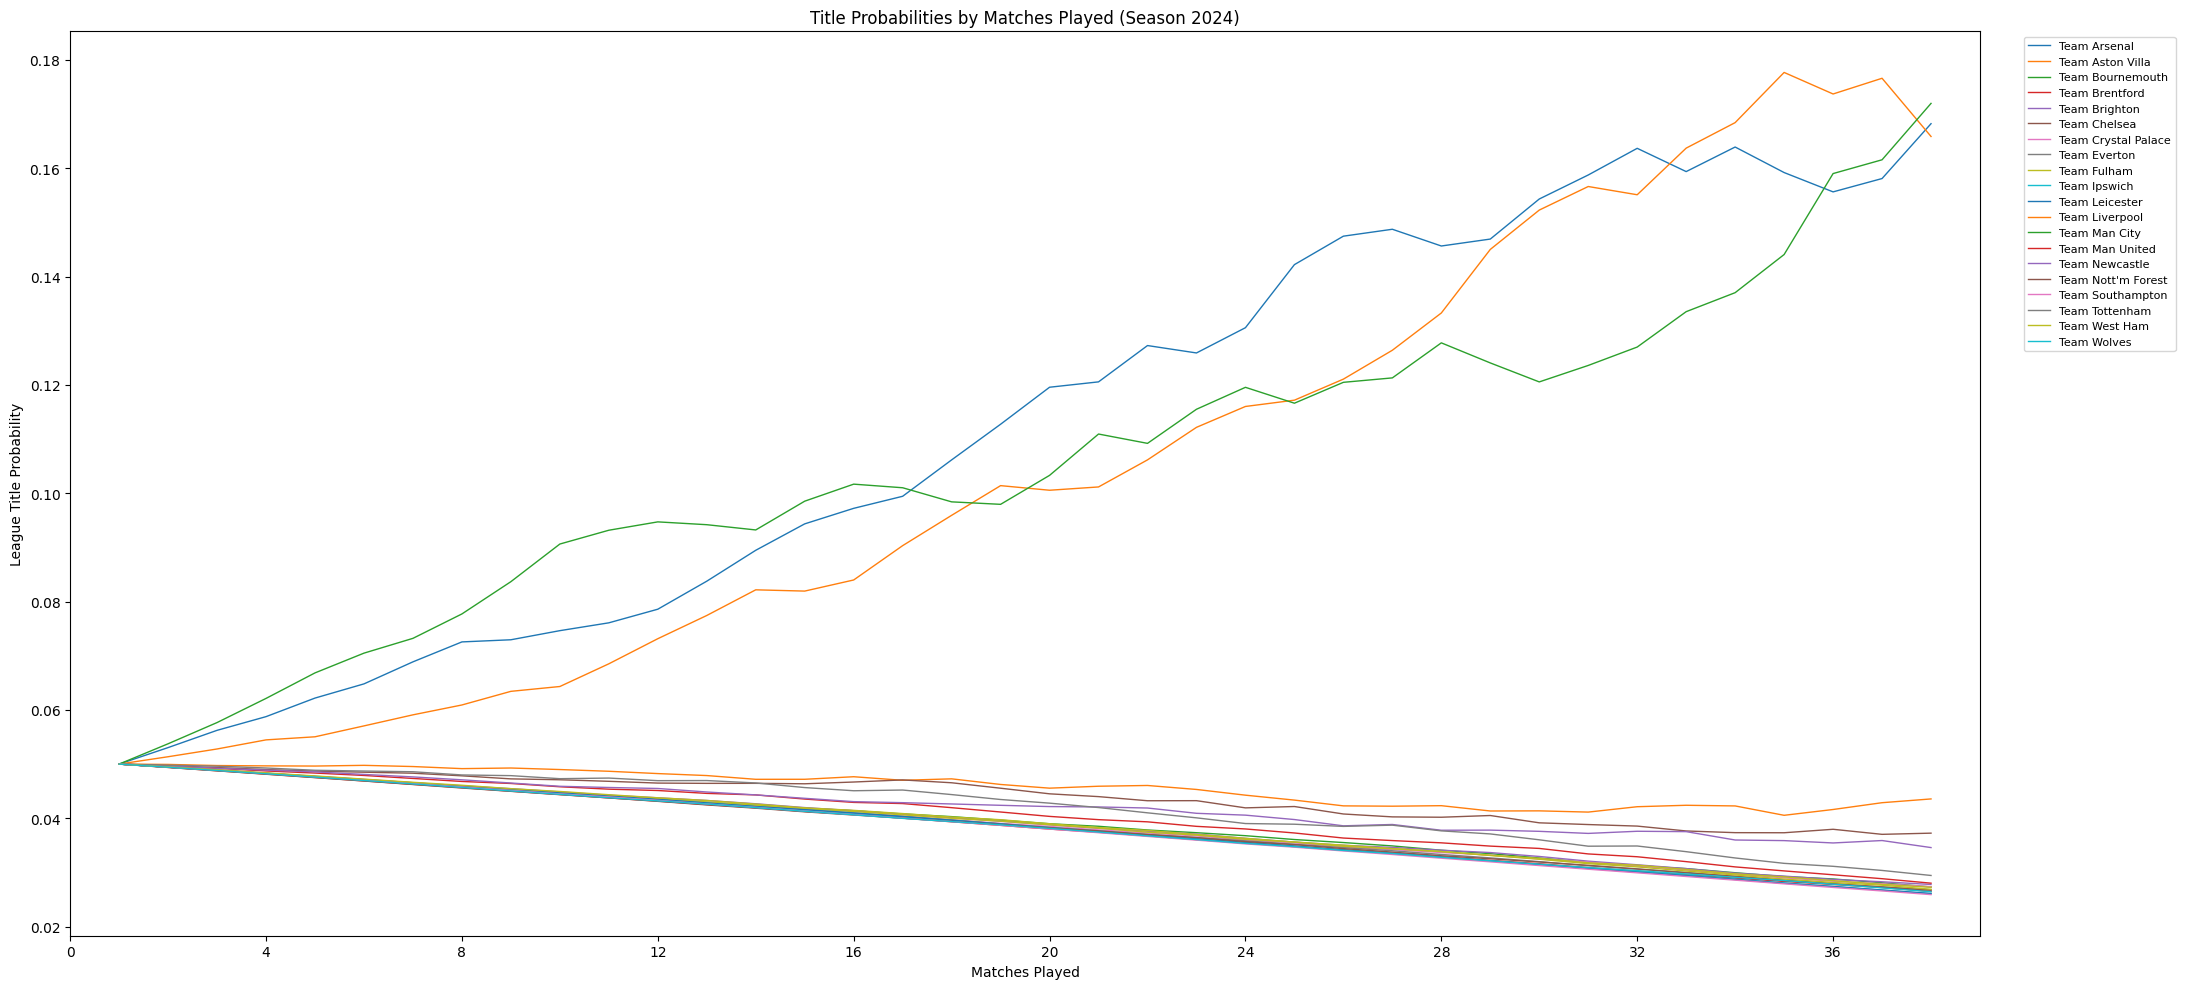

In [63]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle
import matplotlib.ticker as mtick

"""
things to add:
1. more features such as xg and rolegroup performance, rolling averages each gameweek
2. the model learns that if man city have X points by gameweek Y and their players have Z xg, they are more likely to win the league
3. uniformity blend should be adjusted or removed, should be natural
4. try different models such as random forest, xgboost etc.
"""
df2 = df.copy()

TEAM_MATCHES = 38

home = df2[['Date','season_start','gameweek','home_team_encoded','ft_result_encoded']].copy()
away = df2[['Date','season_start','gameweek','away_team_encoded','ft_result_encoded']].copy()

home['team_encoded'] = home.pop('home_team_encoded')
away['team_encoded'] = away.pop('away_team_encoded')

home['points_gain'] = home['ft_result_encoded'].map({2:3,1:1,0:0}).astype(int)
away['points_gain'] = away['ft_result_encoded'].map({2:0,1:1,0:3}).astype(int)

tm = pd.concat([home[['Date','season_start','gameweek','team_encoded','points_gain']],
                away[['Date','season_start','gameweek','team_encoded','points_gain']]],
               ignore_index=True)

tm.sort_values(['season_start','team_encoded','Date','gameweek'], inplace=True)

tm['team_gw']   = tm.groupby(['season_start','team_encoded']).cumcount() + 1
tm['pts_so_far'] = tm.groupby(['season_start','team_encoded'])['points_gain'].cumsum().shift(1).fillna(0.0)
tm['mp_so_far']  = tm['team_gw'] - 1
tm['games_remaining'] = TEAM_MATCHES - tm['mp_so_far']

prev_pts = (tm.groupby(['season_start','team_encoded'])['points_gain'].sum().reset_index()
              .rename(columns={'points_gain':'prev_season_points'}))
prev_pts['season_start'] += 1
tm = tm.merge(prev_pts, on=['season_start','team_encoded'], how='left')
tm['prev_season_points'] = tm['prev_season_points'].fillna(prev_pts['prev_season_points'].mean())

season_totals = tm.groupby(['season_start','team_encoded'])['points_gain'].sum().reset_index()
winners = (season_totals.sort_values(['season_start','points_gain'], ascending=[True,False])
           .groupby('season_start', as_index=False).first()
           .rename(columns={'team_encoded':'winner_team_encoded'}))
tm = tm.merge(winners[['season_start','winner_team_encoded']], on='season_start', how='left')
tm['is_winner'] = (tm['team_encoded'] == tm['winner_team_encoded']).astype(int)


feature_cols = ['pts_so_far','mp_so_far','games_remaining','prev_season_points'] 

print("Using features:", feature_cols)

X_all_raw = tm[feature_cols].astype('float32')
y_all = tm['is_winner'].astype(int)

train_mask = tm['season_start'] !=2024
X_train_raw, y_train = X_all_raw[train_mask], y_all[train_mask]

imp = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_train = scaler.fit_transform(imp.fit_transform(X_train_raw))

clf = LogisticRegression(max_iter=2000, solver='lbfgs')
clf.fit(X_train, y_train)

X_all = scaler.transform(imp.transform(X_all_raw))
tm['logit'] = clf.decision_function(X_all)

def softmax(x, temp=1.0):
    z = (x / temp) - np.max(x / temp)
    e = np.exp(z)
    return e / e.sum()

def temperature_from_mp(mp, total=TEAM_MATCHES, t_max=4.0, t_min=1.0):
    frac = np.clip(mp / total, 0.0, 1.0)
    return t_max - (t_max - t_min) * frac  # 4 -> 1 linearly

tm['title_prob'] = np.nan

for season, g in tm.groupby('season_start', sort=False):
    # regroup by exact mp_so_far instead of nominal GW
    for mp, gg in g.groupby('mp_so_far'):
        # only compute when every team has this mp (aligned round)
        n_teams = g['team_encoded'].nunique()
        if gg['team_encoded'].nunique() != n_teams:
            continue
        temp = temperature_from_mp(mp)
        p_model = softmax(gg['logit'].values)

        # very light early-uniform blend (optional)
        alpha = 0.5 * (mp / TEAM_MATCHES)  # starts 0, ends 0.5
        p = alpha * p_model + (1 - alpha) * (1.0 / n_teams) #midpoint blend

        tm.loc[gg.index, 'title_prob'] = p.astype('float32')

season_plot = 2024
sub = tm[(tm['season_start']==season_plot) & tm['title_prob'].notna()].copy()

with open("pipeline.pkl", "rb") as f: 
    pipeline = pickle.load(f) 
    result_encoder = pipeline["result_encoder"] 
    team_encoder = pipeline['team_encoder']

#turn encoded teams back to names for plotting
sub['team_name'] = team_encoder.inverse_transform(sub['team_encoded'])

plt.figure(figsize=(20,10))
for t, gg in sub.groupby('team_name', sort=False):
    gg = gg.sort_values('mp_so_far')
    plt.plot(gg['mp_so_far']+1, gg['title_prob'], linewidth=1, label=f"Team {t}")  # +1: show 1..38

plt.xlabel('Matches Played')
plt.ylabel('League Title Probability')
plt.xlim(0, 39)
plt.title(f'Title Probabilities by Matches Played (Season {season_plot})')
ax = plt.gca()
ax.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', fontsize=8)
plt.show()


Using features: ['pts_so_far', 'mp_so_far', 'games_remaining', 'prev_season_points', 'xg_for_so_far', 'xg_against_so_far', 'npxg_for_so_far', 'goals_so_far', 'assists_so_far', 'prgc_per90_avg_so_far', 'prgp_per90_avg_so_far', 'prgr_per90_avg_so_far']


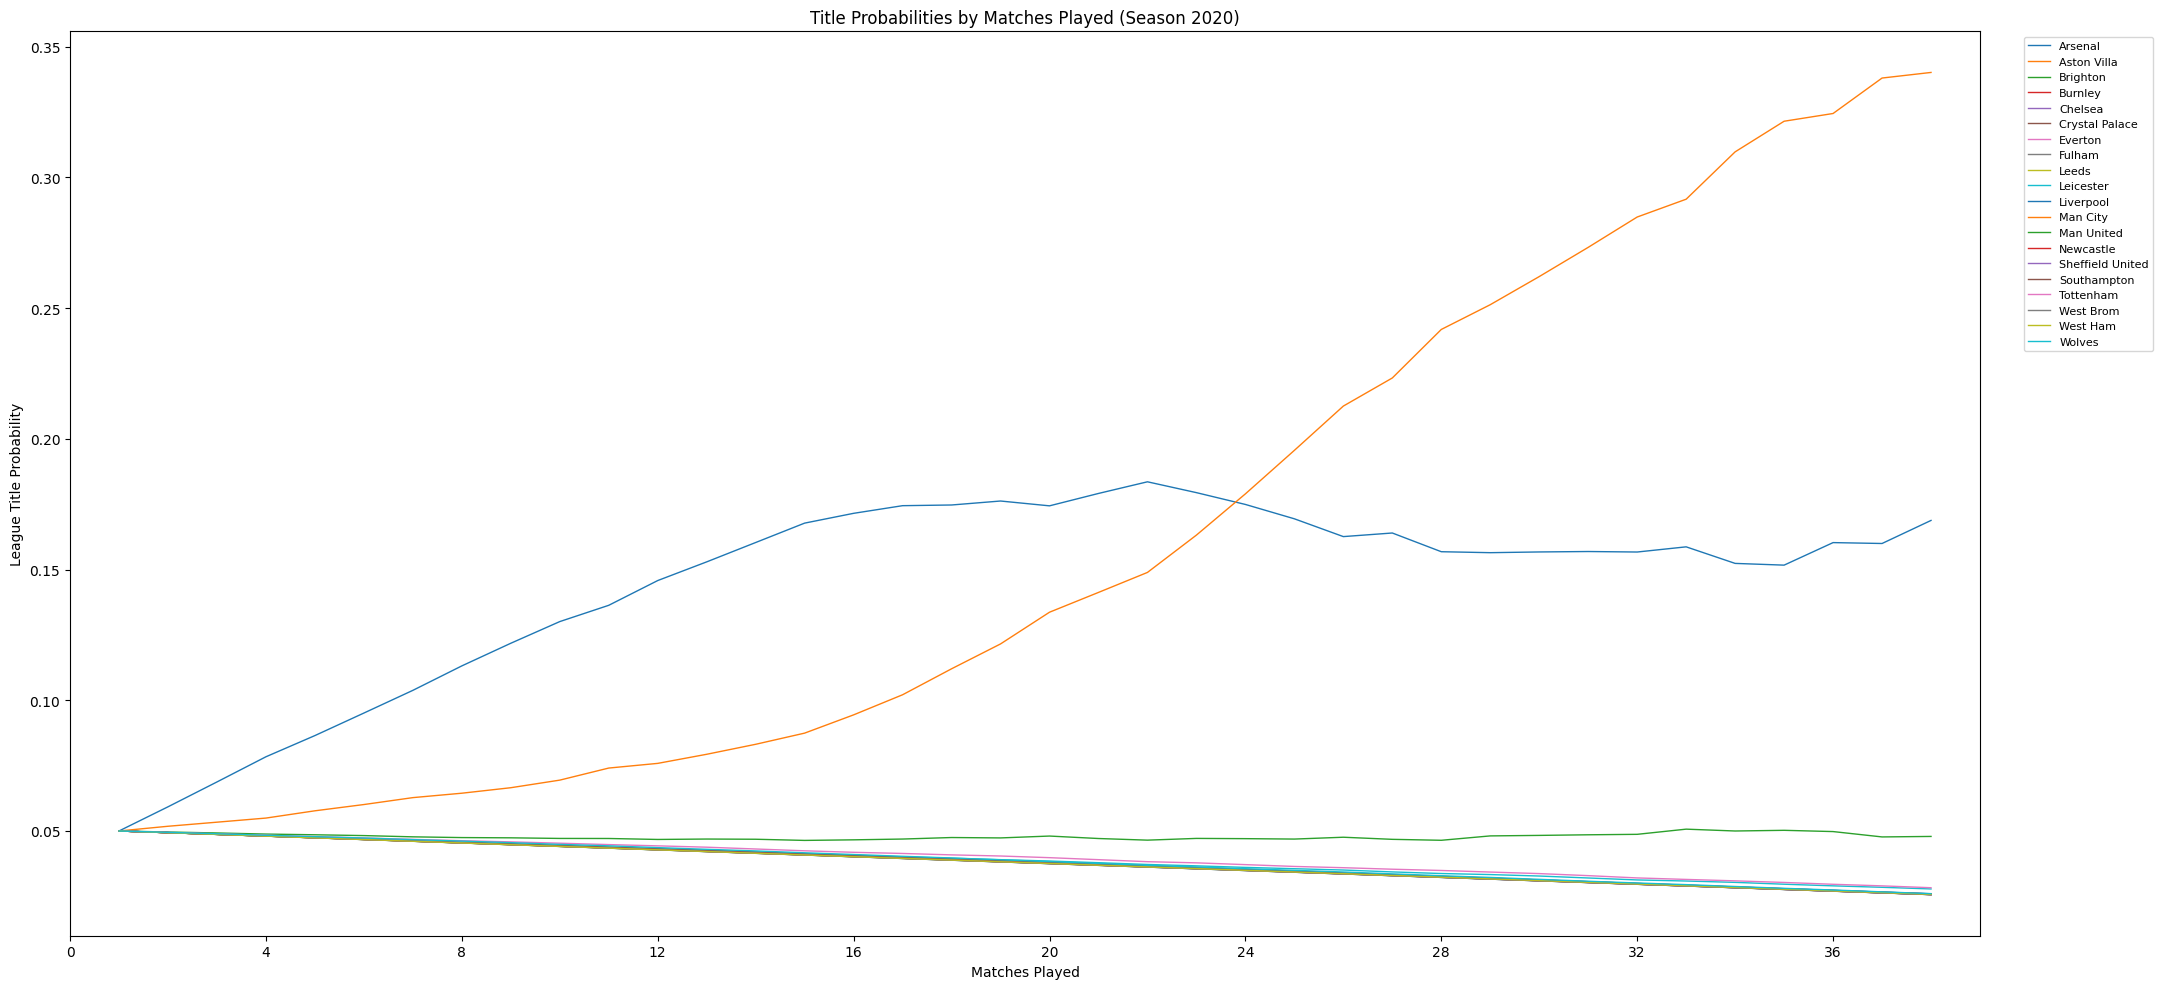

In [77]:
# --------- PARAMETERS ----------
TEAM_MATCHES = 38
SEASON_HOLDOUT = 2020  # keep your current season for evaluation/plotting

# --------- 1) BUILD A TEAM-CENTRIC TABLE WITH PER-MATCH STATS ----------
df2 = df.copy()

# Minimal, robust per-match team stats built from your columns
# (sums over role groups; you can add more later)
def pack_side(side):
    # side: "home" or "away"
    out = pd.DataFrame({
        'Date': df2['Date'],
        'season_start': df2['season_start'],
        'gameweek': df2['gameweek'],
        'team_encoded': df2[f'{side}_team_encoded'],
        'opp_team_encoded': df2[f'{"away" if side=="home" else "home"}_team_encoded'],
        # points gained in THIS match for this side
        'points_gain': df2['ft_result_encoded'].map({2: (3 if side=="home" else 0),
                                                     1: 1,
                                                     0: (0 if side=="home" else 3)}).astype(int),
        # cumulative points already present (if useful)
        'points_cum_given': df2[f'{side}_points_cum'].astype('float32') if f'{side}_points_cum' in df2.columns else np.nan,
        # team xG (sum across role groups)
        'xg_match': df2[f'xG_ATT_{side}'] + df2[f'xG_MID_{side}'] + df2[f'xG_DEF_{side}'],
        'xag_match': df2[f'xAG_ATT_{side}'] + df2[f'xAG_MID_{side}'] + df2[f'xAG_DEF_{side}'],
        'npxg_match': df2[f'npxG_ATT_{side}'] + df2[f'npxG_MID_{side}'] + df2[f'npxG_DEF_{side}'],
        # team G/A (goals+assists) if you want raw outcomes
        'gls_match': df2[f'Gls_ATT_{side}'] + df2[f'Gls_MID_{side}'] + df2[f'Gls_DEF_{side}'],
        'ast_match': df2[f'Ast_ATT_{side}'] + df2[f'Ast_MID_{side}'] + df2[f'Ast_DEF_{side}'],
        # progression summaries (sum ATT/MID/DEF). You can also keep them separate if you prefer.
        'prgc_per90_match': df2[f'PrgC_per90_ATT_{side}'] + df2[f'PrgC_per90_MID_{side}'] + df2[f'PrgC_per90_DEF_{side}'],
        'prgp_per90_match': df2[f'PrgP_per90_ATT_{side}'] + df2[f'PrgP_per90_MID_{side}'] + df2[f'PrgP_per90_DEF_{side}'],
        'prgr_per90_match': df2[f'PrgR_per90_ATT_{side}'] + df2[f'PrgR_per90_MID_{side}'] + df2[f'PrgR_per90_DEF_{side}'],
        # some helpful streak/context fields if present (will be aggregated later)
        'home_win_streak': df2['home_home_win_streak'] if side=='home' and 'home_home_win_streak' in df2 else 0,
        'away_win_streak': df2['away_away_win_streak'] if side=='away' and 'away_away_win_streak' in df2 else 0,
        'total_win_streak': df2[f'{"home" if side=="home" else "away"}_total_win_streak'] if f'{"home" if side=="home" else "away"}_total_win_streak' in df2 else 0,
        'home_lose_streak': df2['home_home_losing_streak'] if side=='home' and 'home_home_losing_streak' in df2 else 0,
        'away_lose_streak': df2['away_away_losing_streak'] if side=='away' and 'away_away_losing_streak' in df2 else 0,
        'total_lose_streak': df2[f'{"home" if side=="home" else "away"}_total_losing_streak'] if f'{"home" if side=="home" else "away"}_total_losing_streak' in df2 else 0,
    })
    # conceded xG = opponent's xG in the same row
    opp = "away" if side=="home" else "home"
    out['xg_against_match'] = df2[f'xG_ATT_{opp}'] + df2[f'xG_MID_{opp}'] + df2[f'xG_DEF_{opp}']
    return out

home_side = pack_side("home")
away_side = pack_side("away")
team_matches = pd.concat([home_side, away_side], ignore_index=True)

# order rows for stable cumulative ops
team_matches.sort_values(['season_start','team_encoded','Date','gameweek'], inplace=True)

# --------- 2) MAKE CUMULATIVE-TO-DATE (UP TO PREVIOUS GAME) FEATURES ----------
g = team_matches.groupby(['season_start','team_encoded'], sort=False)
team_matches['team_gw'] = g.cumcount() + 1
team_matches['mp_so_far'] = team_matches['team_gw'] - 1
team_matches['games_remaining'] = TEAM_MATCHES - team_matches['mp_so_far']

# Helper to make "so far" sums and means (shifted, i.e., up to previous match)
def make_cum_features(df, cols_sum=(), cols_mean=()):
    gg = df.groupby(['season_start','team_encoded'], sort=False)
    for c in cols_sum:
        df[f'{c}_sum_so_far'] = gg[c].cumsum().shift(1).fillna(0.0)
    for c in cols_mean:
        s = gg[c].cumsum().shift(1).fillna(0.0)
        df[f'{c}_avg_so_far'] = (s / df['mp_so_far'].replace(0, np.nan)).fillna(0.0)
    return df

sum_cols  = ['points_gain','xg_match','xag_match','npxg_match','gls_match','ast_match','xg_against_match']
mean_cols = ['prgc_per90_match','prgp_per90_match','prgr_per90_match']

team_matches = make_cum_features(team_matches, cols_sum=sum_cols, cols_mean=mean_cols)

# Simple, interpretable features (keep it small & robust to start)
team_matches['pts_so_far']          = team_matches['points_gain_sum_so_far']
team_matches['xg_for_so_far']       = team_matches['xg_match_sum_so_far']
team_matches['xg_against_so_far']   = team_matches['xg_against_match_sum_so_far']
team_matches['goals_so_far']        = team_matches['gls_match_sum_so_far']
team_matches['assists_so_far']      = team_matches['ast_match_sum_so_far']
team_matches['npxg_for_so_far']     = team_matches['npxg_match_sum_so_far']

# cumulative per-90 progression averages so far
team_matches['prgc_per90_avg_so_far'] = team_matches['prgc_per90_match_avg_so_far']
team_matches['prgp_per90_avg_so_far'] = team_matches['prgp_per90_match_avg_so_far']
team_matches['prgr_per90_avg_so_far'] = team_matches['prgr_per90_match_avg_so_far']

# (Optional) previous season points for context (as in your original code)
prev_pts = (team_matches.groupby(['season_start','team_encoded'])['points_gain']
            .sum().reset_index().rename(columns={'points_gain':'prev_season_points'}))
prev_pts['season_start'] += 1
team_matches = team_matches.merge(prev_pts, on=['season_start','team_encoded'], how='left')
team_matches['prev_season_points'] = team_matches['prev_season_points'].fillna(prev_pts['prev_season_points'].mean())

# --------- 3) MAKE THE TARGET (IS WINNER) ----------
season_totals = (team_matches.groupby(['season_start','team_encoded'])['points_gain']
                 .sum().reset_index())
winners = (season_totals.sort_values(['season_start','points_gain'], ascending=[True,False])
           .groupby('season_start', as_index=False).first()
           .rename(columns={'team_encoded':'winner_team_encoded'}))
team_matches = team_matches.merge(winners[['season_start','winner_team_encoded']], on='season_start', how='left')
team_matches['is_winner'] = (team_matches['team_encoded'] == team_matches['winner_team_encoded']).astype(int)

# --------- 4) TRAIN A SIMPLE MODEL ON PRIOR SEASONS ----------
feature_cols = [
    'pts_so_far','mp_so_far','games_remaining','prev_season_points',
    'xg_for_so_far','xg_against_so_far','npxg_for_so_far',
    'goals_so_far','assists_so_far',
    'prgc_per90_avg_so_far','prgp_per90_avg_so_far','prgr_per90_avg_so_far'
]

print("Using features:", feature_cols)

X_all_raw = team_matches[feature_cols].astype('float32')
y_all = team_matches['is_winner'].astype(int)

train_mask = team_matches['season_start'] != SEASON_HOLDOUT
X_train_raw, y_train = X_all_raw[train_mask], y_all[train_mask]

imp = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_train = scaler.fit_transform(imp.fit_transform(X_train_raw))

clf = LogisticRegression(max_iter=2000, solver='lbfgs')
clf.fit(X_train, y_train)

X_all = scaler.transform(imp.transform(X_all_raw))
team_matches['logit'] = clf.decision_function(X_all)

# --------- 5) CONVERT TO PER-SEASON, PER-MATCH PROBABILITIES ----------
def softmax(x, temp=1.0):
    z = (x / temp) - np.max(x / temp)
    e = np.exp(z)
    return e / e.sum()

def temperature_from_mp(mp, total=TEAM_MATCHES, t_max=4.0, t_min=1.0):
    frac = np.clip(mp / total, 0.0, 1.0)
    return t_max - (t_max - t_min) * frac  # 4 -> 1 linearly

team_matches['title_prob'] = np.nan

for season, g in team_matches.groupby('season_start', sort=False):
    # regroup by exact mp_so_far instead of nominal GW (ensures aligned rounds)
    n_teams = g['team_encoded'].nunique()
    for mp, gg in g.groupby('mp_so_far'):
        if gg['team_encoded'].nunique() != n_teams:
            continue  # skip unaligned rounds
        temp = temperature_from_mp(mp)
        p_model = softmax(gg['logit'].values)

        # very light early uniform blend (optional)
        alpha = 0.0 +  0.5* (mp / TEAM_MATCHES)  # starts 0.5, ends 1
        p = alpha * p_model + (1 - alpha) * (1.0 / n_teams)

        team_matches.loc[gg.index, 'title_prob'] = p.astype('float32')

# --------- 6) PLOT YOUR HOLDOUT SEASON ----------
season_plot = SEASON_HOLDOUT
sub = team_matches[(team_matches['season_start']==season_plot) & team_matches['title_prob'].notna()].copy()

# If you have your pipeline with encoders, use it to get names
try:
    with open("pipeline.pkl", "rb") as f: 
        pipeline = pickle.load(f) 
        team_encoder = pipeline['team_encoder']
    sub['team_name'] = team_encoder.inverse_transform(sub['team_encoded'])
except Exception:
    sub['team_name'] = sub['team_encoded'].astype(str)

plt.figure(figsize=(20,10))
for t, gg in sub.groupby('team_name', sort=False):
    gg = gg.sort_values('mp_so_far')
    plt.plot(gg['mp_so_far']+1, gg['title_prob'], linewidth=1, label=f"{t}")
plt.xlabel('Matches Played')
plt.ylabel('League Title Probability')
plt.xlim(0, 39)
plt.title(f'Title Probabilities by Matches Played (Season {season_plot})')
ax = plt.gca()
ax.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', fontsize=8)
plt.show()
